In [162]:
#!pip3 install pandas
#!pip3 install numpy
#!pip3 install seaborn
#!pip3 install matplotlib
#!pip3 install scipy
#!pip3 install statsmodels

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Import data 

The dataset used comes from the [Ireland football results dataset](https://www.football-data.co.uk/ireland.php) on https://www.football-data.co.uk/. This website tracks hstoric match results across a number of leagues and is a great resource for this analysis.

In [8]:
loi_df = pd.read_csv('data/loi_results.csv')

# create a game_id columns
loi_df['game_id'] = loi_df.index
loi_df['Date'] = loi_df['Date'].astype('datetime64[ns]')

# limit to games in 2020
loi_df = loi_df.loc[loi_df['Date'] > '2020-01-01 00:00:00']
loi_df['total_goals'] = loi_df['HG'] + loi_df['AG']
loi_df.head()

,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,...,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,game_id,total_goals
1560,Ireland,Premier Division,2020,2020-02-14,19:45,Cork City,Shelbourne,0,1,A,...,3.31,3.65,2.20,3.43,3.95,2.11,3.17,3.48,1560,1
1561,Ireland,Premier Division,2020,2020-02-14,19:45,Dundalk,Derry City,1,0,H,...,4.01,6.87,1.55,4.24,7.23,1.50,3.96,6.34,1561,1
1562,Ireland,Premier Division,2020,2020-02-14,19:45,St. Patricks,Waterford,0,1,A,...,3.17,4.49,2.02,3.91,5.52,1.86,3.27,4.34,1562,1
1563,Ireland,Premier Division,2020,2020-02-14,20:00,Finn Harps,Sligo Rovers,1,0,H,...,3.03,2.66,3.05,3.15,3.23,2.80,2.98,2.63,1563,1
1564,Ireland,Premier Division,2020,2020-02-15,14:00,Bohemians,Shamrock Rovers,0,1,A,...,3.11,2.21,3.90,3.42,2.21,3.62,3.00,2.13,1564,1


# Plot goals per game to understand distribution

<ipython-input-135-fcca3671eb8a>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


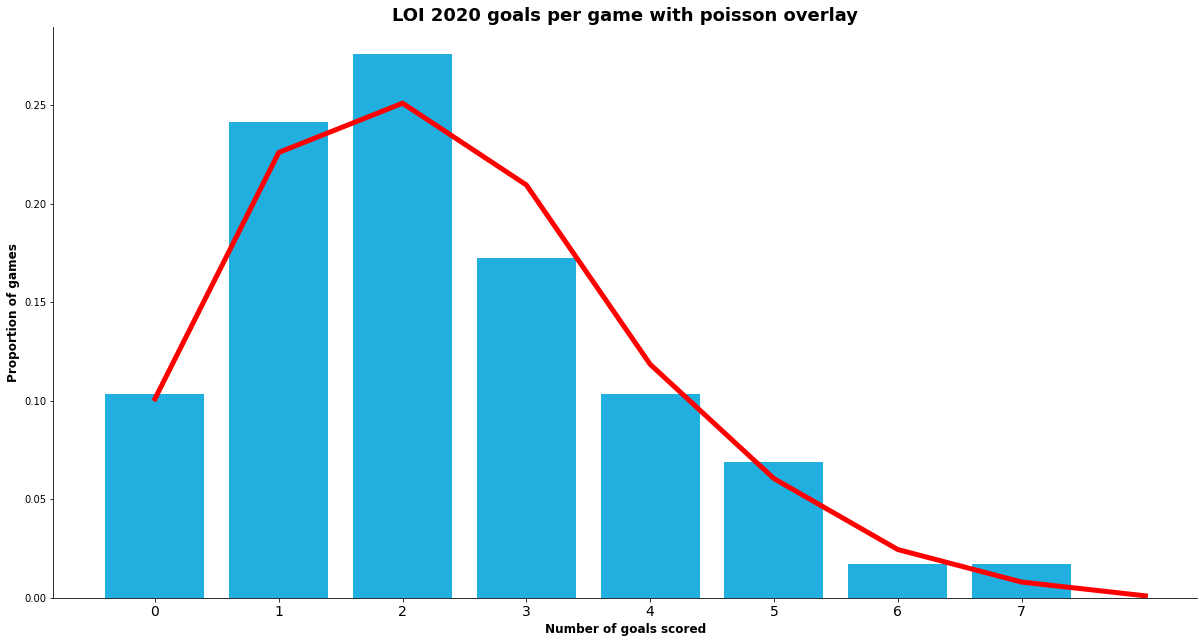

In [135]:
viz_df = loi_df.groupby('total_goals')['game_id'].count().reset_index()
viz_df.columns = ['total_goals', 'number_of_matches']
viz_df['proportion_of_goals'] = viz_df['number_of_matches']/len(loi_df)

# generate 2000 points distributed according to a poisson distribution to overlay
mean_goals = loi_df['total_goals'].mean()
poisson_dist = pd.DataFrame({'goals_scored': list(poisson.rvs(mean_goals, size=2000))}).reset_index()
poisson_dist = poisson_dist.groupby('goals_scored')['index'].count().reset_index()
poisson_dist['proportion_of_goals'] = poisson_dist['index']/2000

fig, ax = plt.subplots()
fig.set_size_inches(20.5, 10.5)

# plot our boxplot and
ax = sns.barplot(
    x='total_goals', y='proportion_of_goals', data=viz_df, color='deepskyblue'
)

ax = sns.lineplot(
    x='goals_scored', y='proportion_of_goals', data=poisson_dist, color='red', linewidth=5, markers=True
)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set and format titles
ax.set_title("LOI 2020 goals per game with poisson overlay", fontdict={'fontsize':18, 'fontweight':'bold'})
ax.set_xlabel("Number of goals scored", fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_ylabel("Proportion of games", fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_xticklabels(ax.get_xticklabels(), size=14)
plt.savefig('goals_per_game_with_poisson.png')
fig.show()

# Basic poisson model 

Since we are comfortable that the goals per game are distributed according to a poisson distribution, we can calculate simple probabilities for the number of goals a team will score in a game using the following formula:

$$P(x) = \frac{e^{- \lambda}\lambda^x}{x!}$$

Where $x$ is the number of goals a team will score and $\lambda$ the average number of goals scored by the team per game.

## Transform data into a better format

Lets transform the data into a format whereby each row represents a single teams performance in a given game. Having the data in this format will make things easier for our modelling later on.

In [36]:
home_df = loi_df[['game_id', 'Date', 'Home', 'HG', 'Away', 'AG', 'Res']]
away_df = loi_df[['game_id', 'Date', 'Away', 'AG', 'Home', 'HG', 'Res']]

home_df.columns = away_df.columns = ['game_id', 'game_date', 'team', 'goals_scored', 'opponent', 'goals_conceded', 'result']

home_df['at_home'] = 1
away_df['at_home'] = 0

# tidy up result column
home_df['outcome'] = 'draw'
home_df.loc[home_df['result']=='H', 'outcome'] = 'win'
home_df.loc[home_df['result']=='A', 'outcome'] = 'loss'

# tidy up result column
away_df['outcome'] = 'draw'
away_df.loc[home_df['result']=='A', 'outcome'] = 'win'
away_df.loc[home_df['result']=='H', 'outcome'] = 'loss'

team_results_df = pd.concat([home_df, away_df])
team_results_df.head()

<ipython-input-36-df01d9e9d474>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_df['at_home'] = 1
<ipython-input-36-df01d9e9d474>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_df['at_home'] = 0
<ipython-input-36-df01d9e9d474>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,game_id,game_date,team,goals_scored,opponent,goals_conceded,result,at_home,outcome
1560,1560,2020-02-14,Cork City,0,Shelbourne,1,A,1,loss
1561,1561,2020-02-14,Dundalk,1,Derry City,0,H,1,win
1562,1562,2020-02-14,St. Patricks,0,Waterford,1,A,1,loss
1563,1563,2020-02-14,Finn Harps,1,Sligo Rovers,0,H,1,win
1564,1564,2020-02-15,Bohemians,0,Shamrock Rovers,1,A,1,loss


## Calculate average goals for each team

In [68]:
goals_for_against = team_results_df.groupby('team')[['goals_scored']].mean().reset_index()
goals_for_against

,team,goals_scored
0,Bohemians,1.083333
1,Cork City,0.545455
2,Derry City,1.000000
3,Dundalk,2.000000
4,Finn Harps,0.666667
5,Shamrock Rovers,2.500000
6,Shelbourne,0.833333
7,Sligo Rovers,1.166667
8,St. Patricks,0.500000
9,Waterford,1.250000


## Use this approach to calculate the probability that a team will score x goals 

Now that we have the expected goals for each team, we can plug these values into the formula described above to answer some questions.

### What is the probability that shamrock rovers will score 3 goals in a game? 

In [24]:
number_of_goals = 3
expected_goals = goals_for_against.loc[goals_for_against['team']=='Shamrock Rovers', 'goals_scored'].values[0]

prob = poisson.pmf(number_of_goals, expected_goals)
prob

0.21376301724973648

### What is the probability of Finn Harps scoring 3 goals in a match? 

In [25]:
number_of_goals = 3
expected_goals = goals_for_against.loc[goals_for_against['team']=='Finn Harps', 'goals_scored'].values[0]

prob = poisson.pmf(number_of_goals, expected_goals)
prob

0.02535393180407862

### What is the probability that shamrck rovers will score 2 or more goals?

This is simplly $1 - P($scoring 0 or 1 goals$)$

In [27]:
expected_goals = goals_for_against.loc[goals_for_against['team']=='Shamrock Rovers', 'goals_scored'].values[0]

prob = poisson.pmf(0, expected_goals) + poisson.pmf(1, expected_goals)
1 - prob 

0.7127025048163542

# Now lets take into account the opponent and home field advantage 

While the basic approach described above can help us get to grips with the poisson distribution and the idea of predicting goal probabilities, it fails to take into account the quality of the opponent and any home field advantage which may be in play.

We can get around this however by fitting a Poisson regression model (since the response variable is poisson distributed) which will predict the expected number of goals scored a team will score against a particular opponent with home field advantage in mind.

Of course we can add any number of variables to this model (e.g. avaerage passes per team, possession, etc.) as they are available, however for the purposes of this tutorial the three mentioned above will suffice.

Thankfully for us, we can very easily fit a poisson regression using the [statsmodels library](https://www.statsmodels.org/stable/index.html), as demonstrated below.

In [136]:
poisson_model = smf.glm(
    formula="goals_scored ~ at_home + team + opponent", data=team_results_df, family=sm.families.Poisson()
).fit()

When we take a look at the output below, the first thing that we notice is that there is a lot of information. However for the purposes of understanding the predictions will work, the main things we are interested in are the values in the `coeff` column. These values represent what we will pass into the poisson regression model formula to calculate the expected goals a team will score.

Let us illustrate this by means of an example:

Consider we want to put a bet on how many goals Shamrock Rovers will score in their upcoming home fixture against Sligo Rovers. We would begin by pulling the `intercept`, `team[T.Shamrock Rovers]`, `opponent[T.Sligo Rovers]`, and `home` values from the table below (not if the team you want to detrmine the expected goals for is playing away you can leave out the `home` value).

From here, we can simply plug these in to the poisson regression formula:

$$ \lambda = E[Y | x] = e^{\theta x}$$

Where $\theta$ is the sum of our coefficient values.

Doing this we get:

$$ \lambda = e^{-0.9015 + 0.8445 + 1.0866 + 0.2439} = 3.57$$

Amazingly, our model tells us that Shamrock Rovers are in for a big day when they play Sligo with an expected goals haul  of 3.57!

Of course we don't always have to do this by hand as (statsmodels)[(https://www.statsmodels.org/stable/index.html)] provides a handy `predict()` function which we will use in our simulations (see below).

In [156]:
poisson_model.predict(
    pd.DataFrame(data={'team': 'Shamrock Rovers', 'opponent': 'Sligo Rovers', 'at_home':1},index=[1])
).values[0]

3.5736065212859063

In [137]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           goals_scored   No. Observations:                  116
Model:                            GLM   Df Residuals:                       96
Model Family:                 Poisson   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -142.57
Date:                Thu, 24 Sep 2020   Deviance:                       108.54
Time:                        19:02:54   Pearson chi2:                     92.5
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.9015      0.490     -1.841      0.066      -1.861       0.058
team[T.Cork City]              -0.5431      0.496     -1.095      0.274      -1.516       0.429
team[T.Derry City]             -0.0451      0.414     -0.109      0.913      -0.856       0.766
team[T.Dundalk]                 0.7030      0.361      1.946      0.052      -0.005       1.411
team[T.Finn Harps]             -0.3908      0.453     -0.863      0.388      -1.278       0.497
team[T.Shamrock Rovers]         0.8445      0.338      2.501      0.012       0.183       1.506
team[T.Shelbourne]             -0.3009      0.426     -0.707      0.480      -1.136       0.534
team[T.Sligo Rovers]            0.1805      0.393      0.459      0.646      -0.590       0.951
team[T.St. Patricks]           -0.7889      0.495     -1.593      0.111      -1.759       0.181
team[T.Waterford]               0.3345      0.386      0.868      0.386      -0.421       1.090
opponent[T.Cork City]           1.0723      0.445      2.411      0.016       0.200       1.944
opponent[T.Derry City]          0.6402      0.496      1.290      0.197      -0.333       1.613
opponent[T.Dundalk]             1.0800      0.467      2.313      0.021       0.165       1.995
opponent[T.Finn Harps]          1.0935      0.445      2.457      0.014       0.221       1.966
opponent[T.Shamrock Rovers]     0.2414      0.541      0.447      0.655      -0.818       1.301
opponent[T.Shelbourne]          0.6912      0.474      1.459      0.145      -0.237       1.620
opponent[T.Sligo Rovers]        1.0866      0.461      2.356      0.018       0.183       1.991
opponent[T.St. Patricks]        0.4028      0.495      0.814      0.416      -0.567       1.373
opponent[T.Waterford]           1.0273      0.451      2.277      0.023       0.143       1.911
at_home                         0.2439      0.178      1.367      0.172      -0.106       0.594
===============================================================================================
"""

A few quick points to note here before moving on:

1. You will notice that Bohs don't appear anywhere in this summary. This isn't because I am a Shamrock Rovers fan but rather because since they appear first alphabetically, they are the intercept for the model. So you can think of all other coefficient values as that teams attacking of sefensive strength compared to Bohs. For example if a team has a positive coefficient value, it will mean they are a superior attacking team to Bohs, whereas an team with a negative coefficient can be considered inferior as an attacking threat. Conversely, an opponent with a positive coefficient can be considered a worse team defensivly, while an opponent with a negative coefficent can be considered a better defensive team.


2. With point 1 in mind, we can use the coefficient values to rank teams within the league. For example, since there are no negative values in the opponent section, we can say that Bohs are the most solid defensive team in the league, on the other hand, we can say that Shamrock Rovers are the best attacking team


3. Finally, you will notice that the p-value for `at_home` is equal to 0.172. This is interesting as it suggests that this particular vairbale is not a significant predictior in our model, and that there has been no home field advantage in the 2020 season. This makes sense intuitively due to the impact of coronavirus on fans attending matches and it could be an exercise for the readon to repeat this analysis on the 2019 data to determine if this variable was significant then!

## Use the expected goals based on opponent and home field advantage to run simulations and determine scoreline probabilities

Now that we have a mechanism for calculating the expected goals for a team given their opponent, we can use this information with the basic model discussed earlier to generate probalities for match scorelines

To do this we will define a function which calculates the expected goals for the home and away team, then iterativly calculates the probability of them scoring N goals in that match befor creating a square matrix of result probabilities.

The match I will focus on will be tomorrow's Bohemians v Derry City game.

In [157]:
def simulate_match(poisson_model, home_team, away_team, max_goals=5):
    # calculate home team expected goals using our poisson regression model
    home_team_expected_goals = poisson_model.predict(
        pd.DataFrame(data={'team': home_team, 'opponent': away_team, 'at_home':1},index=[1])
    )
    
    # calculate away team expected goals using the same model
    away_team_expected_goals = poisson_model.predict(
        pd.DataFrame(data={'team': away_team, 'opponent': home_team, 'at_home':0},index=[1])
    )
    
    # now loop through all possible goal combinations and determine the probability of that scoreline
    team_goals_prob = [
        [poisson.pmf(i, expected_goals) for i in range(0, max_goals+1)] for expected_goals in [
            home_team_expected_goals, away_team_expected_goals
        ]
    ]
    
    return(np.outer(np.array(team_goals_prob[0]), np.array(team_goals_prob[1])))

<ipython-input-158-26857b794f4b>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


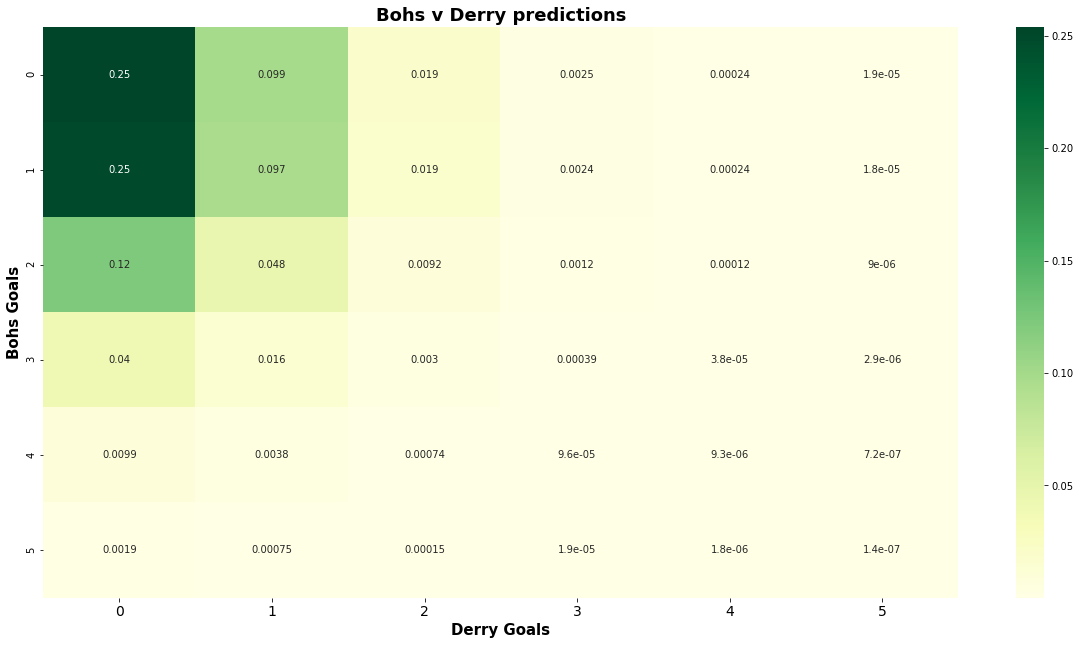

In [158]:
match_score_probabilities = simulate_match(
    poisson_model, "Bohemians", "Derry City"
)


fig, ax = plt.subplots()
fig.set_size_inches(20.5, 10.5)

# plot our boxplot and
ax = sns.heatmap(match_score_probabilities, annot=True, cmap="YlGn")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set and format titles
ax.set_title("Bohs v Derry predictions", fontdict={'fontsize':18, 'fontweight':'bold'})
ax.set_xlabel("Derry Goals", fontdict={'fontsize':15, 'fontweight':'bold'})
ax.set_ylabel("Bohs Goals", fontdict={'fontsize':15, 'fontweight':'bold'})
ax.set_xticklabels(ax.get_xticklabels(), size=14)
plt.savefig('sample_output.png')
fig.show()

In [72]:
match_score_probabilities = simulate_match(
    poisson_model, "Bohemians", "Derry City"
)

bohs_win = round(np.sum(np.tril(match_score_probabilities, -1)), 2)
draw = round(np.sum(np.diag(match_score_probabilities)), 2)
derry_win = round(np.sum(np.triu(match_score_probabilities, 1)), 2)

print(f"Probability Bohs win: {bohs_win}\nProbability of a draw: {draw}\nProbability Derry win: {derry_win}")

Probability Bohs win: 0.5
Probability of a draw: 0.36
Probability Derry win: 0.14
